In [1]:
#first i need data from a previous run
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, metrics, Model
from tensorflow.keras.callbacks import Callback
from scipy.stats import truncnorm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import numpy as np
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py
import datetime
from scipy.optimize import curve_fit
import math
from scipy import asarray as ar,exp
import pylab as plb
import tqdm
from tqdm import tqdm
import time
import progressbar
import sys

In [2]:
dataset = np.load("/home/roberts/O-PPAC/recomplied_dataset_fixed.npy")
all_data = dataset[ : , :132]
all_labels = dataset[: , -2:]

print(all_data.shape)
print(all_labels.shape)

(338636, 132)
(338636, 2)


In [3]:
#separate the test data as done above
x1_data_all = (all_data[: , :33])
x2_data_all = (all_data[:, 33:66])
y1_data_all = (all_data[:, 66:99])
y2_data_all = (all_data[:, 99:132])

#labels kept so they have the same indices
x_labels_all = all_labels[ : , 0 ]
y_labels_all = all_labels[ : , 1 ]

print(x1_data_all.shape)
print(x_labels_all.shape)

(338636, 33)
(338636,)


In [4]:
#adding 10 units of padding to the front and back of dataset diodes for fitting
def padding(data_arr):
    return np.pad(data_arr, [(0,0), (10, 10)], 'constant')

In [5]:
x1_data_pad = padding(x1_data_all)
x2_data_pad = padding(x2_data_all)
y1_data_pad = padding(y1_data_all)
y2_data_pad = padding(y2_data_all)

In [6]:
np.set_printoptions(threshold=sys.maxsize)
print(x1_data_pad[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00381202 0.         0.         0.         0.00381202
 0.         0.02287213 0.15629286 0.16010488 0.23253328 0.20203711
 0.10292457 0.01524808 0.         0.00381202 0.         0.
 0.00381202 0.         0.         0.         0.00381202 0.00381202
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


In [7]:
print(x1_data_all[0])

[0.         0.         0.         0.00381202 0.         0.
 0.         0.00381202 0.         0.02287213 0.15629286 0.16010488
 0.23253328 0.20203711 0.10292457 0.01524808 0.         0.00381202
 0.         0.         0.00381202 0.         0.         0.
 0.00381202 0.00381202 0.         0.         0.         0.
 0.         0.         0.        ]


In [8]:
#gaussian fit function
def gaussianpdf(x, k, sigma, mu):
    return k*np.exp(-(x-mu)**2/(2*sigma**2))

In [9]:
#function to (hopefully) fit gaussians (and thus, centroids which is what we want) onto all data sets
def centroiddn(x, y):
    try:
        if np.max(y) > 20:
            kvalue = np.max(y)+(np.max(y)/2)
        elif np.max(y) == 0:
            kvalue = 1
        else:
            kvalue = np.max(y)
        popt, _ = curve_fit(gaussianpdf, x, y, bounds=(0, [kvalue,10., 33.]))
        return popt[2]
    except RuntimeError:
        return -5555

In [10]:
def fit_peaks(x_data, y_data):
    fit_peaks = []
    for i in tqdm(range(y_data.shape[0])):
        fit_peaks.append(centroiddn(x_data, y_data[i,:]))
    return np.array(fit_peaks)

In [11]:
def find_peak_error(arr1data, arr2data):
    error_indices1 = np.where(arr1data == -5555 )
    error_indices2 = np.where(arr2data == -5555 )
        
    error_indices = np.unique(np.concatenate([error_indices1, error_indices2], axis = 1))
        
    return error_indices

In [12]:
def remove_peak_error(arr1data, arr2data, removearr):
    
    arr1data_df = pd.DataFrame(arr1data)
    arr2data_df = pd.DataFrame(arr2data)
        
    arr1data_df_fixed = arr1data_df.drop(arr1data_df.index[removearr])
    arr2data_df_fixed = arr2data_df.drop(arr2data_df.index[removearr])
        
    arr1data_fixed = arr1data_df_fixed.to_numpy()
    arr2data_fixed = arr2data_df_fixed.to_numpy()
    
    arr1data = np.reshape(arr1data_fixed, -1)
    arr2data = np.reshape(arr2data_fixed, -1)
    
    return arr1data, arr2data

def remove_peak_error_single(arr1data, removearr):
    arr1data_df = pd.DataFrame(arr1data)
    arr1data_df_fixed = arr1data_df.drop(arr1data_df.index[removearr])
    arr1data_fixed = arr1data_df_fixed.to_numpy()
    arr1data = np.reshape(arr1data_fixed, -1)
    return arr1data

In [13]:
def remove_label_indices(labels, indices):
    labels = pd.DataFrame(labels)
    labels_fixed = labels.drop(labels.index[indices])
    labels = labels_fixed.to_numpy()
    return np.reshape(labels, -1)

def remove_label_indices_noresh(labels, indices):
    labels = pd.DataFrame(labels)
    labels_fixed = labels.drop(labels.index[indices])
    return labels_fixed.to_numpy()
    

In [14]:
#conversions from diode number to millimeters and vice versa
#might need to be updated if Yassid sends a better method of converting
def diodenum_to_mm(arr1data):
    return (arr1data /33)*100 - 48

def mm_to_diodenum(arr1data):
    return ((arr1data + 48)/100)*33

In [15]:
def average(arr1data, arr2data):
    avg = (arr1data + arr2data)/2
    return avg

In [16]:
def peak_recompile(arr1, arr2, arrerror):
    arr1, arr2 = remove_peak_error(arr1, arr2, arrerror)
    avg_peaks = average(arr1, arr2)
    mm_peaks = diodenum_to_mm(avg_peaks)
    return avg_peaks, mm_peaks

In [17]:
rangemin = 0
rangemax = 30000

ranges = (rangemin, rangemax)
range_size = rangemax - rangemin

x1_data = x1_data_pad[rangemin:rangemax]
x2_data = x2_data_pad[rangemin:rangemax]
y1_data = y1_data_pad[rangemin:rangemax]
y2_data = y2_data_pad[rangemin:rangemax]

x_labels = x_labels_all[rangemin:rangemax]
y_labels = y_labels_all[rangemin:rangemax]

x1_data_fitting = x1_data_all[rangemin:rangemax]
x2_data_fitting = x2_data_all[rangemin:rangemax]
y1_data_fitting = y1_data_all[rangemin:rangemax]
y2_data_fitting = y2_data_all[rangemin:rangemax]

print(len(x_labels))
print(x1_data.shape)

30000
(30000, 53)


In [ ]:
x1_peaks = fit_peaks(np.arange(0,53,1), x1_data)

In [ ]:
np.save("x1_peaks_file_5", x1_peaks)

In [ ]:
x2_peaks = fit_peaks(np.arange(0,53,1), x2_data)

In [ ]:
np.save("x2_peaks_file_5", x2_peaks)

In [ ]:
y1_peaks = fit_peaks(np.arange(0,53,1), y1_data)

In [ ]:
np.save("y1_peaks_file_5", y1_peaks)

In [ ]:
y2_peaks = fit_peaks(np.arange(0,53,1), y2_data)

In [ ]:
np.save("y2_peaks_file_5", y2_peaks)

In [18]:
#importing data so I'm not running over the other kernels
x1_peaks = np.load("x1_peaks_file_5.npy")
x2_peaks = np.load("x2_peaks_file_5.npy")
y1_peaks = np.load("y1_peaks_file_5.npy")
y2_peaks = np.load("y2_peaks_file_5.npy")

print(len(x1_peaks))
print(len(x2_peaks))
print(len(y1_peaks))
print(len(y2_peaks))

print(x1_peaks.shape)

30000
30000
30000
30000
(30000,)


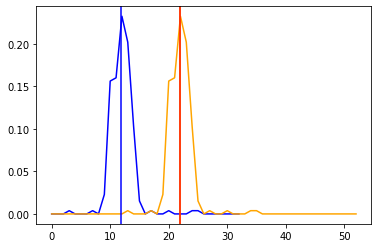

In [19]:
num = 0

plt.plot(x1_data_fitting[num], color='blue')
plt.plot(x1_data[num], color = 'orange')
plt.axvline(x = x1_peaks[num], color = 'yellow')
plt.axvline(x = x2_peaks[num], color = 'red')
plt.axvline(x = mm_to_diodenum(x_labels[num]), color ="blue")
plt.show()

In [20]:
x_errors = find_peak_error(x1_peaks, x2_peaks)
y_errors = find_peak_error(y1_peaks, y2_peaks)

all_error_indices = np.unique(np.concatenate([x_errors, y_errors]))

all_error_indices = np.array(all_error_indices)
np.save("all_error_indices", all_error_indices)
print(len(all_error_indices))

22


In [21]:
x1_peaks = x1_peaks - 10
x2_peaks = x2_peaks - 10
y1_peaks = y1_peaks - 10
y2_peaks = y2_peaks - 10

In [22]:
x_peaks, x_peaks_mm = peak_recompile(x1_peaks, x2_peaks, all_error_indices)

In [23]:
y_peaks, y_peaks_mm = peak_recompile(y1_peaks, y2_peaks, all_error_indices)

In [24]:
x_labels = remove_label_indices(x_labels, all_error_indices)
y_labels = remove_label_indices(y_labels, all_error_indices)

print(x_labels.shape)
print(x_peaks_mm.shape)
print(y_labels.shape)
print(y_peaks_mm.shape)

(29978,)
(29978,)
(29978,)
(29978,)


In [25]:
x1_data = remove_label_indices_noresh(x1_data, all_error_indices)
x2_data = remove_label_indices_noresh(x2_data, all_error_indices)
y1_data = remove_label_indices_noresh(y1_data, all_error_indices)
y2_data = remove_label_indices_noresh(y2_data, all_error_indices)

In [26]:
x1_data_fitting = remove_label_indices_noresh(x1_data_fitting, all_error_indices)
x2_data_fitting = remove_label_indices_noresh(x2_data_fitting, all_error_indices)
y1_data_fitting = remove_label_indices_noresh(y1_data_fitting, all_error_indices)
y2_data_fitting = remove_label_indices_noresh(y2_data_fitting, all_error_indices)

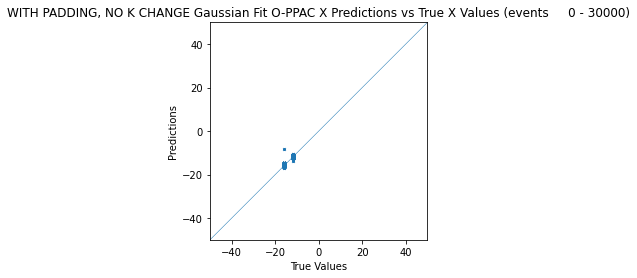

In [27]:
#graph showing the accuracy of gaussian fit by comparing predicted and true x values
#should be as close to the diagonal as possible
a = plt.axes(aspect='equal')

plt.scatter(x_labels, x_peaks_mm, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("WITH PADDING, NO K CHANGE Gaussian Fit O-PPAC X Predictions vs True X Values (events %5.0f - %5.0f)" %tuple(ranges))
plt.show()

In [28]:
#to find the locations of largest error within my predicted x values
x_error = np.abs(x_peaks_mm - x_labels)

print(x_error.shape)

problem_indices_x = [idx for (idx, err) in enumerate(x_error) if err >= 2]
print(len(problem_indices_x))

(29978,)
1


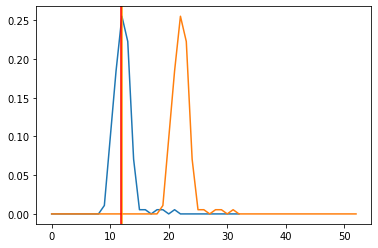

In [29]:
plt.plot(y1_data_fitting[34])
plt.plot(y1_data[34])
plt.axvline(x = y_peaks[34], color="orange")
plt.axvline(x = mm_to_diodenum(y_labels[34]), color="red")
plt.show()

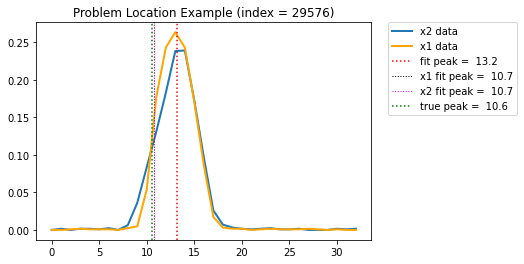

In [30]:
i = 0 #choose the index of the error (above)
true_x = mm_to_diodenum(x_labels[problem_indices_x[i]])

plt.title('Problem Location Example (index = %5.0f)' %(problem_indices_x[i]+rangemin))
plt.plot(x2_data_fitting[problem_indices_x[i]], linewidth = 2, label = "x2 data")
plt.plot(x1_data_fitting[problem_indices_x[i]], linewidth = 2, color='orange', label = "x1 data")
plt.axvline(x = x_peaks[problem_indices_x[i]], color = "red", linestyle=":",label = "fit peak = %5.1f" %x_peaks[problem_indices_x[i]])
plt.axvline(x = x1_peaks[problem_indices_x[i]], color = "black", linewidth = 1, linestyle=":", label = "x1 fit peak = %5.1f" % x1_peaks[problem_indices_x[i]])
plt.axvline(x = x2_peaks[problem_indices_x[i]], color = "magenta", linewidth = 1, linestyle=":", label = "x2 fit peak = %5.1f" % x2_peaks[problem_indices_x[i]])
plt.axvline(x = true_x, color = "green", linestyle=":",label = "true peak = %5.1f" %true_x)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [56]:
#basic gaussian fit stuff; needs x and y inputs for all data points; index is both for the y data and for lower code
index = 29564
x = np.arange(0,33,1)
y = x2_data_fitting[index,:]

print(y)
x_labels_index = index

#the true location of the peak as given by the label for that event
x_peak_true_value = ((x_labels[x_labels_index]+48)/100)*33
x_peak_fit_value = x_peaks[x_labels_index]

[0.         0.         0.         0.         0.         0.
 0.         0.00643793 0.05794135 0.12875855 0.22854643 0.25107918
 0.17060508 0.08047409 0.01931378 0.00321896 0.         0.00643793
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00321896 0.00321896
 0.         0.         0.        ]


In [57]:
#curve fit code; bounds might be able to be played with still to improve model (specifically sigma in index 1)
#trying new stuff to better balance k based on the input data
if np.max(y) > .20:
    kvalue = np.max(y)+(np.max(y)/2)
elif np.max(y) == 0:
    kvalue = 1
else:
    kvalue = np.max(y)

popt, _ = curve_fit(gaussianpdf, x, y, bounds=(0, [kvalue,10., 33.]))
print(popt[2])
print(x_peak_true_value)
print(x_peak_fit_value)

10.695526366463355
10.56
10.687785260134898


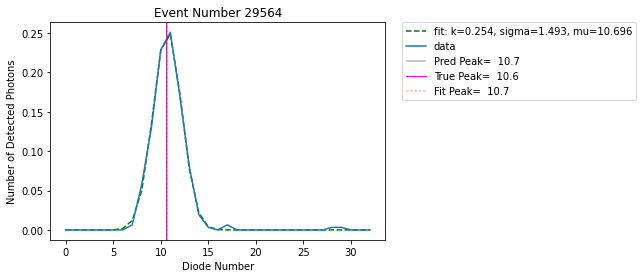

In [58]:
#plotting gaussian to make sure it looks logically correct
plt.plot(x, gaussianpdf(x, *popt), 'g--', label='fit: k=%5.3f, sigma=%5.3f, mu=%5.3f' % tuple(popt))
plt.plot(x2_data_fitting[index,:], label = "data")
plt.axvline(x = x_peak_fit_value, color = "black", linewidth=.4, label='Pred Peak= %5.1f' %x_peak_fit_value)
plt.axvline(x = x_peak_true_value, color = "magenta", linewidth=1, label='True Peak= %5.1f' % x_peak_true_value)
plt.axvline(x = popt[2], color = "red", linewidth=.4, linestyle='dashdot', label='Fit Peak= %5.1f' %popt[2])
plt.title('Event Number %5.0f' %index)
plt.xlabel('Diode Number')
plt.ylabel('Number of Detected Photons')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

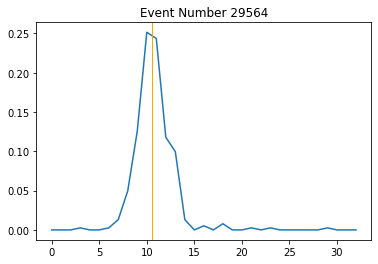

In [61]:
plt.title('Event Number %5.0f' %index)
plt.plot(all_data[index][33:66])
plt.axvline(x=mm_to_diodenum(x_labels[index]), linewidth = 1, color='orange')
#plt.axvline(x=x2_peaks[index]+33, linewidth = 1, color='orange')
#plt.axvline(x=y1_peaks[index]+66, linewidth = 1, color='orange')
#plt.axvline(x=y2_peaks[index]+99, linewidth = 1, color='orange')
plt.show

In [35]:
y1_peaks_mm = diodenum_to_mm(y1_peaks)
print(y1_peaks_mm.shape)
print(y_labels.shape)

y1_peaks_mm = remove_peak_error_single(y1_peaks_mm, all_error_indices)

(30000,)
(29978,)


In [36]:
print(y1_peaks_mm.shape)

(29978,)


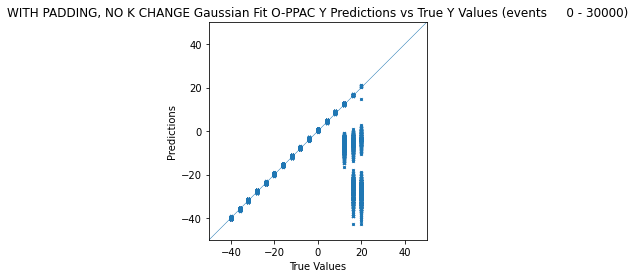

In [37]:
#graph showing the accuracy of gaussian fit by comparing predicted and true y values
#should be as close to the diagonal as possible
a = plt.axes(aspect='equal')

plt.scatter(y_labels, y_peaks_mm, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("WITH PADDING, NO K CHANGE Gaussian Fit O-PPAC Y Predictions vs True Y Values (events %5.0f - %5.0f)" %tuple(ranges))
plt.show()

In [38]:
#to find the locations of largest error within my predicted x values
y_error = np.abs(y_peaks_mm - y_labels)

print(y_error.shape)

problem_indices_y = [idx for (idx, err) in enumerate(y_error) if err >= 10]
print(len(problem_indices_y))

(29978,)
5347


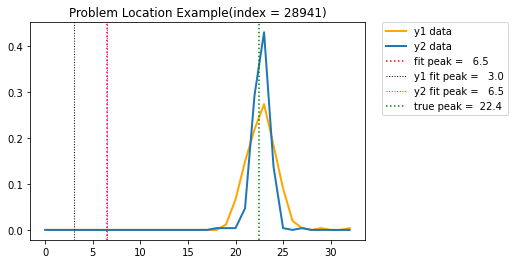

In [40]:
#graph locations of large y error
i = 4589 #choose the index of the error (above)
true_y = mm_to_diodenum(y_labels[problem_indices_y[i]])

plt.title('Problem Location Example(index = %5.0f)' %(problem_indices_y[i]+rangemin))
plt.plot(y1_data_fitting[problem_indices_y[i]], linewidth = 2, color='orange', label = "y1 data")
plt.plot(y2_data_fitting[problem_indices_y[i]], linewidth = 2, label = "y2 data")
plt.axvline(x = y_peaks[problem_indices_y[i]], color = "red", linestyle=":",label = "fit peak = %5.1f" %y_peaks[problem_indices_y[i]])
plt.axvline(x = y1_peaks[problem_indices_y[i]], color = "black", linewidth = 1, linestyle=":", label = "y1 fit peak = %5.1f" % y1_peaks[problem_indices_y[i]])
plt.axvline(x = y2_peaks[problem_indices_y[i]], color = "magenta", linewidth = 1, linestyle=":", label = "y2 fit peak = %5.1f" % y2_peaks[problem_indices_y[i]])
plt.axvline(x = true_y, color = "green", linestyle=":",label = "true peak = %5.1f" %true_y)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [ ]:
#basic gaussian fit stuff; needs x and y inputs for all data points; index is both for the y data and for lower code
index = 10925
x = np.arange(0,33,1)
y = y2_data_fitting[index,:]

print(y)
y_labels_index = index

#the true location of the peak as given by the label for that event
y_peak_true_value = ((y_labels[y_labels_index]+48)/100)*33
y_peak_fit_value = y_peaks[y_labels_index]

In [ ]:
#curve fit code; bounds might be able to be played with still to improve model (specifically sigma in index 1)
#trying new stuff to better balance k based on the input data
if np.max(y) > .20:
    kvalue = np.max(y)+(np.max(y)/2)
elif np.max(y) == 0:
    kvalue = 1
else:
    kvalue = np.max(y)

popt, _ = curve_fit(gaussianpdf, x, y, bounds=(0, [kvalue,10., 33.]))
print(popt[2])
print(y_peak_true_value)
print(y_peak_fit_value)

In [ ]:
#plotting gaussian to make sure it looks logically correct
plt.plot(x, gaussianpdf(x, *popt), 'g--', label='fit: k=%5.3f, sigma=%5.3f, mu=%5.3f' % tuple(popt))
plt.plot(y2_data_fitting[index,:], label = "data")
plt.axvline(x = y_peak_fit_value, color = "black", linewidth=.4, label='Pred Peak= %5.1f' %y_peak_fit_value)
plt.axvline(x = y_peak_true_value, color = "magenta", linewidth=1, label='True Peak= %5.1f' % y_peak_true_value)
plt.axvline(x = popt[2], color = "red", linewidth=.4, linestyle='dashdot', label='Fit Peak= %5.1f' %popt[2])
plt.title('Event Number %5.0f' %index)
plt.xlabel('Diode Number')
plt.ylabel('Number of Detected Photons')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()